In [64]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
from PIL import Image
import random
from tqdm import tqdm

In [65]:
IMG_DIMS = (256, 256)
BATCH_SIZE = 16
LEARNING_RATES = [0.01, 0.001, 0.0001]

# Dataset info
DEFOCUSED_BLURRED = "defocused_blurred"
SHARP = "sharp"

In [66]:
sharp_images_folder = os.listdir(SHARP)

In [67]:
zipped_paths = []
for blured_image_path in os.listdir(DEFOCUSED_BLURRED):
    number = blured_image_path.split("_")[0]
    sharp_image_path = list(filter(lambda x: x.split("_")[0] == number, sharp_images_folder))[0]
    blured_image_path = f"{DEFOCUSED_BLURRED}/{blured_image_path}"
    sharp_image_path = f"{SHARP}/{sharp_image_path}"
    zipped_paths.append([blured_image_path, sharp_image_path])

In [68]:
zipped_paths[:5]

[['defocused_blurred/216_ASUS-ZENFONE-LIVE-ZB501KL_F.jpg',
  'sharp/216_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg'],
 ['defocused_blurred/0_IPHONE-SE_F.JPG', 'sharp/0_IPHONE-SE_S.JPG'],
 ['defocused_blurred/15_HONOR-7C_F.jpg', 'sharp/15_HONOR-7C_S.jpg'],
 ['defocused_blurred/270_NIKON-D3400-18-55MM_F.JPG',
  'sharp/270_NIKON-D3400-18-55MM_S.JPG'],
 ['defocused_blurred/292_NIKON-D3400-35MM_F.JPG',
  'sharp/292_NIKON-D3400-35MM_S.JPG']]

In [69]:
class DefoccusedAndMotionBluredDataset(Dataset):
    def __init__(self, data, transforms) -> None:
        super().__init__()
        self.ln = len(data)
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return self.ln
        
    def __getitem__(self, index):
        defocused, sharp = self.data[index]
        
        defocused = Image.open(defocused)
        sharp = Image.open(sharp)
        
        return self.transforms(defocused), self.transforms(sharp)

In [70]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMG_DIMS),
    torchvision.transforms.ToTensor(),
])

In [71]:
ds = DefoccusedAndMotionBluredDataset(zipped_paths, transforms)
dataloader = DataLoader(ds, BATCH_SIZE, True)

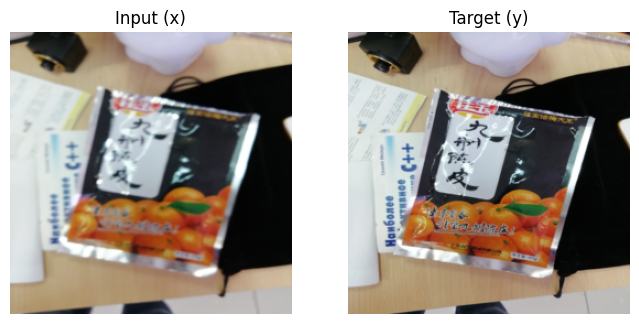

In [72]:
x, y = next(iter(dataloader))

index = 0

# Convert tensor to numpy array and permute dimensions to (H, W, C)
x_sample = x[index].permute(1, 2, 0).numpy()
y_sample = y[index].permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_sample)
plt.title("Input (x)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(y_sample)
plt.title("Target (y)")
plt.axis("off")

plt.show()

In [73]:
class EncoderBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(inp, out, 3, 1, 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out),
            nn.AvgPool2d(2),
        )
    
    def forward(self, x):
        return self.layers(x)

In [74]:
class DecoderBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(inp, out, 3, 1, 1),
            nn.BatchNorm2d(out),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [75]:
class DeblurrerModel(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        
        self.encoder_block1 = EncoderBlock(channels, channels)
        self.encoder_block2 = EncoderBlock(channels, channels)
        self.encoder_block3 = EncoderBlock(channels, channels)
        self.encoder_block4 = EncoderBlock(channels, channels)
        self.encoder_block5 = EncoderBlock(channels, channels)
        
        self.dencoder_block1 = DecoderBlock(channels, channels)
        self.dencoder_block2 = DecoderBlock(channels, channels)
        self.dencoder_block3 = DecoderBlock(channels, channels)
        self.dencoder_block4 = DecoderBlock(channels, channels)
        self.dencoder_block5 = DecoderBlock(channels, channels)
        
        self.first_conv = nn.Conv2d(3, channels, 1)
        self.finish_conv = nn.Conv2d(channels, 3, 1)
        
    def forward(self, x):
        
        fs = self.first_conv(x)
        eout1 = self.encoder_block1(fs) # 128
        eout2 = self.encoder_block2(eout1) # 64
        eout3 = self.encoder_block3(eout2) # 32
        eout4 = self.encoder_block4(eout3) # 16
        eout5 = self.encoder_block5(eout4) # 8
        
        dout1 = self.dencoder_block1(eout5) # 16
        dout1 += eout4
        
        dout2 = self.dencoder_block2(dout1) # 32
        dout2 += eout3
        
        dout3 = self.dencoder_block3(dout2) # 64
        dout3 += eout2
        
        dout4 = self.dencoder_block4(dout3) # 128
        dout4 += eout1
        
        dout5 = self.dencoder_block4(dout4) # 256
        dout5 += fs

        return self.finish_conv(dout5)

In [76]:
class Deblurrer:
    def __init__(self, dataloader: DataLoader, channels: int = 128, epochs: int = 100, learning_rates: list[int] = LEARNING_RATES):
        self.dataloader = dataloader
        
        self.model = DeblurrerModel(channels)
        self.optimizer = Adam(self.model.parameters())
        
        self.epochs = epochs
        
        self.criterion = nn.MSELoss()
        
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        print("Training on:", self.device)
        
        self.model.to(self.device)
    
    def train(self):
        for epoch in range(self.epochs):
            for x, y in tqdm(self.dataloader):
                x = x.to(self.device)
                y = y.to(self.device)
                
                self.optimizer.zero_grad()
                self.model.train()
                
                out = self.model(x)
                loss = self.criterion(out, y)

                
                loss.backward()
                self.optimizer.step()
            
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item()}")
            self.sample()
    
    def sample(self):
        ln = len(self.dataloader.dataset)
        random_index = random.randint(0, ln - 1)
        x, y = self.dataloader.dataset[random_index]
        
        columns = 1
        rows = 3
        
        titles = ["Focus Blur", "Focus Blur After Model", "Sharp"]
        
        self.model.eval()
        with torch.no_grad():
            deblurred = self.model(x.unsqueeze(0).to(self.device))
        
        if deblurred.dim() == 4:
            deblurred = deblurred.squeeze(0)
        
        deblurred = deblurred.detach().cpu().permute(1, 2, 0).numpy()
        x = x.permute(1, 2, 0).numpy()
        y = y.permute(1, 2, 0).numpy()
        
        fig = plt.figure(figsize=(15, 15))
        cnt = 0
        for i in range(1, 4):
            fig.add_subplot(columns, rows, i)
            plt.title(titles[cnt])
            if cnt == 0:  # Wyświetl wejściowy rozmyty obraz
                plt.imshow(x)
            elif cnt == 1:  # Wyświetl deblurowany obraz
                plt.imshow(deblurred)
            else:  # Wyświetl ostry obraz referencyjny
                plt.imshow(y)
            plt.axis("off")
            cnt += 1
            
        plt.show()

In [77]:
deblurrer = Deblurrer(dataloader)

Training on: cpu


In [78]:
deblurrer.sample()

KeyboardInterrupt: 

100%|██████████| 22/22 [06:37<00:00, 18.08s/it]


Epoch [1/100], Loss: 0.051306623965501785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


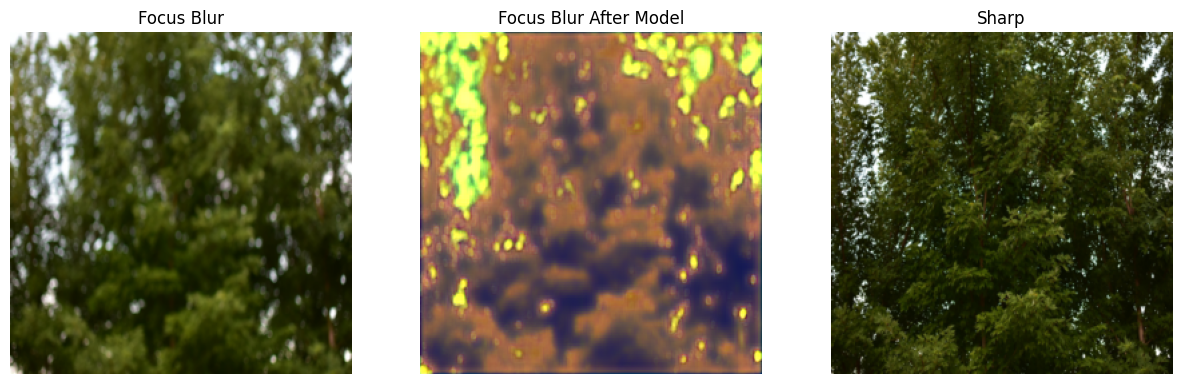

  5%|▍         | 1/22 [00:37<13:01, 37.21s/it]


KeyboardInterrupt: 

In [ ]:
deblurrer.train()